**任务时间：题目1-3（11.05-11.10）
题目4、5（11.12-11.17）
题目6（11.19-11.25）**

**互评与筛选时间：题目1-3（11.11）
题目4、5（11.18）
题目6（11.26）**

每周只用提交相应的部分到自己的git，试题实行每周淘汰制

新互评链接：https://yiqixie.com/s/home/fcACT-kZRz10FXWBU2jXDt8VO

# 1、成功读取BTCUSDT:binance的数据，绘出30Min和1H的gap图

'start_date':20180601000000

In [1]:
import warnings

warnings.filterwarnings('ignore')

from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'BTCUSDT:binance', 'freq': '30Min,1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props)
print(time()-start)

3.831984758377075


In [2]:
#调用模块
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv30M = HFDataView()
dv1H = HFDataView()

In [3]:
dv30M.create_init_dv(Time_dict['30Min'].dropna().set_index(["trade_date","symbol"]))
dv1H.create_init_dv(Time_dict['1H'].dropna().set_index(["trade_date","symbol"]))

Initialize dataview success.
Initialize dataview success.


In [4]:
Gap1H = dv1H.add_formula('gap', 'close-Delay(open, 1)',add_data=True)
Gap30 = dv30M.add_formula('gap', 'close-Delay(open, 1)',add_data=True)

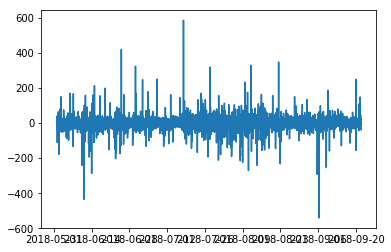

In [5]:
#观察价差
import matplotlib.pyplot as plt


plt.plot(dv30M.get_ts('gap', date_type='datetime'))
plt.show()

In [6]:
#30min的图

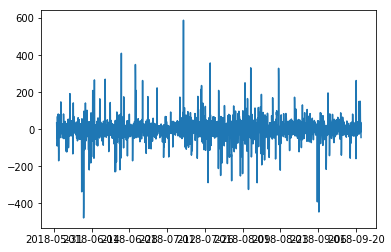

In [7]:
plt.plot(dv1H.get_ts('gap', date_type='datetime'))
plt.show()

In [8]:
#1H的图

# 2、调用alpha101research中的alpha10进行绘图，定义事件，打印绩效

要求：

1、绘出alpha10_dv30M_ma5_ma20、alpha10_dv1H_ma5_ma20的图。

2、定义alpha10的金叉死叉事件，周期为20和55，并打印出long_short的绩效

In [9]:
for dvAdd in [dv30M, dv1H]:
    dvAdd.add_formula('alpha10_C','If(Ts_Min(Delta(close,1),4)>0,Delta(close,1),If((Ts_Max(Delta(close,1),4)<0),Delta(close,1),(-1*Delta(close,1))))',add_data=True)

In [10]:
import matplotlib.pyplot as plt

def Plot_Mean(dv, alpha, chart_name='dv_alpha_ma', ShortPeriod=20, LongPeriod=55, n=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax1.plot(alpha.iloc[n:], alpha=0.1)
    ax1.plot(pd.Series(alpha.rolling(ShortPeriod).mean(), index=alpha.index).iloc[n:])
    ax1.plot(pd.Series(alpha.rolling(LongPeriod).mean(), index=alpha.index).iloc[n:])
#     plt.savefig(chart_name)
    plt.show()

In [11]:
dv_dict = {'alpha1_dv30M':dv30M, 'alpha1_dv1H':dv1H}
alpha1_dict = {n: dv.get_ts('alpha10_C', date_type='datetime') for n, dv in dv_dict.items()}

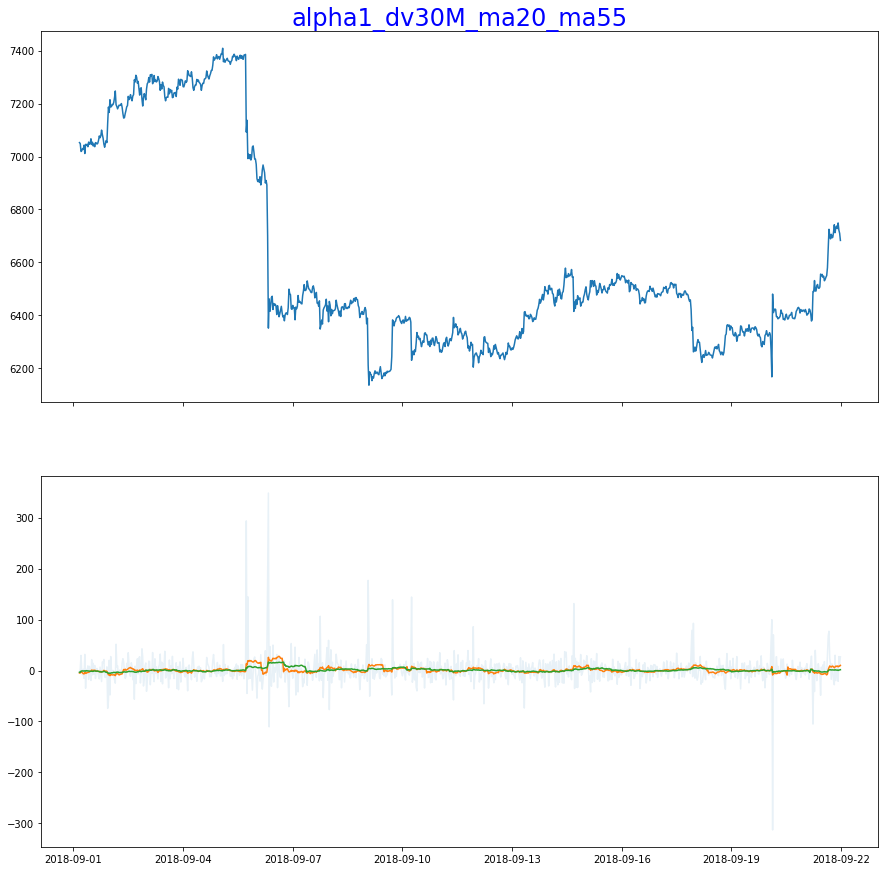

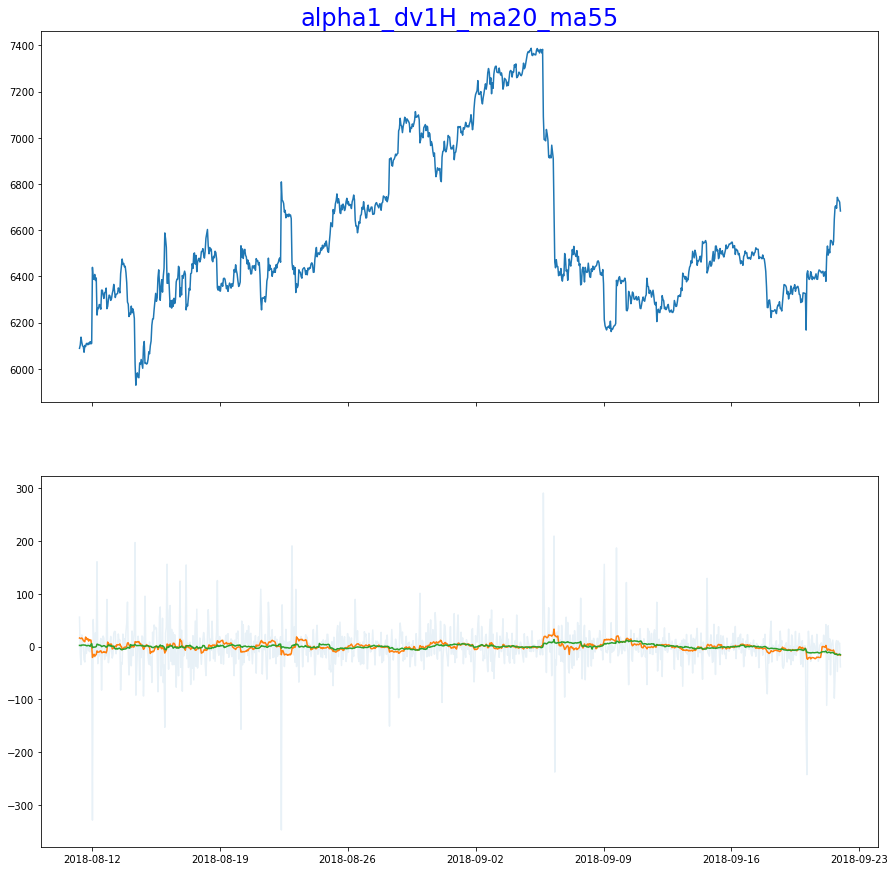

In [12]:
import pandas as pd
#alpha1_dv15M是15分钟线，1H是1小时线，ma30和ma60代表对信号进行均线处理和观察是否与价格存在涨跌关系
for name, alpha in alpha1_dict.items():
    Plot_Mean(globals()[name.split('_')[1]], alpha.iloc[:,0], chart_name=name+'_ma20_ma55',ShortPeriod=20, LongPeriod=50, n=-1000)#橘色短线 绿色长线

In [13]:
# 进场信号
long = dv1H.add_formula("longAlpha10","If((Ts_Mean(alpha10_C,20)>Ts_Mean(alpha10_C,55)) && (Delay(Ts_Mean(alpha10_C,20),1)<=Delay(Ts_Mean(alpha10_C,55),1)),2,0)", add_data=True)
short = dv1H.add_formula("shortAlpha10","If((Ts_Mean(alpha10_C,20)<Ts_Mean(alpha10_C,55)) && (Delay(Ts_Mean(alpha10_C,20),1)>=Delay(Ts_Mean(alpha10_C,55),1)),-2,0)", add_data=True)

# 出场信号
close_long = dv1H.add_formula("closeLongAlpha10","If(shortAlpha10==-2,1,0)", add_data=True)
close_short = dv1H.add_formula("closeShortAlpha10","If(longAlpha10==2,-1,0)", add_data=True)

In [14]:
dv1H.get_ts('longAlpha10').stack()[dv1H.get_ts('longAlpha10').stack()==2].tail()

trade_date      symbol         
20180919050000  BTCUSDT:binance    2.0
20180919080000  BTCUSDT:binance    2.0
20180919110000  BTCUSDT:binance    2.0
20180919160000  BTCUSDT:binance    2.0
20180920230000  BTCUSDT:binance    2.0
dtype: float64

In [15]:
from jaqs_fxdayu.research import TimingDigger

tdAlpha10 = TimingDigger(output_folder=".", output_format='pdf',signal_name='Alpha0010')

def TimingSignal(td, dv, long='long', short='short',closeLong='closeLong', closeShort='closeShort'\
                 , mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

TimingSignal(tdAlpha10, dv1H,'longAlpha10','shortAlpha10','closeLongAlpha10','closeShortAlpha10', 100, 0.05, 0.3)

/anaconda3/lib/python3.7/site-packages/jaqs/research/signaldigger/plotting.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 497, in start
    self.io_loop.start()
  File "/anaconda3/lib/python3

Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%


In [16]:
tdAlpha10.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat                8.290   -9.095   -0.145
p-value               0.000    0.000    0.885
mean                  0.011   -0.011   -0.000
std                   0.016    0.015    0.019
info_ratio            0.677   -0.738   -0.008
skewness              3.664   -1.974    0.697
kurtosis             17.554    2.909    8.470
pct5                  0.001   -0.049   -0.032
pct25                 0.002   -0.012   -0.005
pct50                 0.005   -0.005   -0.000
pct75                 0.012   -0.002    0.005
pct95                 0.041   -0.001    0.027
occurance           151.000  153.000  304.000
win_ratio               NaN      NaN    0.497
win_mean/loss_mean      NaN      NaN    0.984


# 3、打印出Morningstar事件的时间点，绘出Morningstar与成交量的图

数据类型要求：'symbol': 'BTCUSDT:binance',

'freq': '1H','start_date':20180601000000

In [17]:
start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'BTCUSDT:binance', 'freq': '1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props)
print(time()-start)

3.383531093597412


In [18]:
import matplotlib.pyplot as plt
import mpl_finance as mpf

def draw_candle(candle, scatterX, scatterY):
    fig, (ax, ax1) = plt.subplots(2,1,sharex=True, figsize=(18,10))
    ax.grid(True)
    mpf.candlestick_ohlc(ax, candle, width=0.3, colorup='r', colordown='g',alpha=1.0)
    ax.scatter(scatterX, scatterY, color='b', s=100, marker='^')
    ax.xaxis_date ()
    ax1.bar(data1H.index, data1H.volume)
    plt.show()

Initialize dataview success.


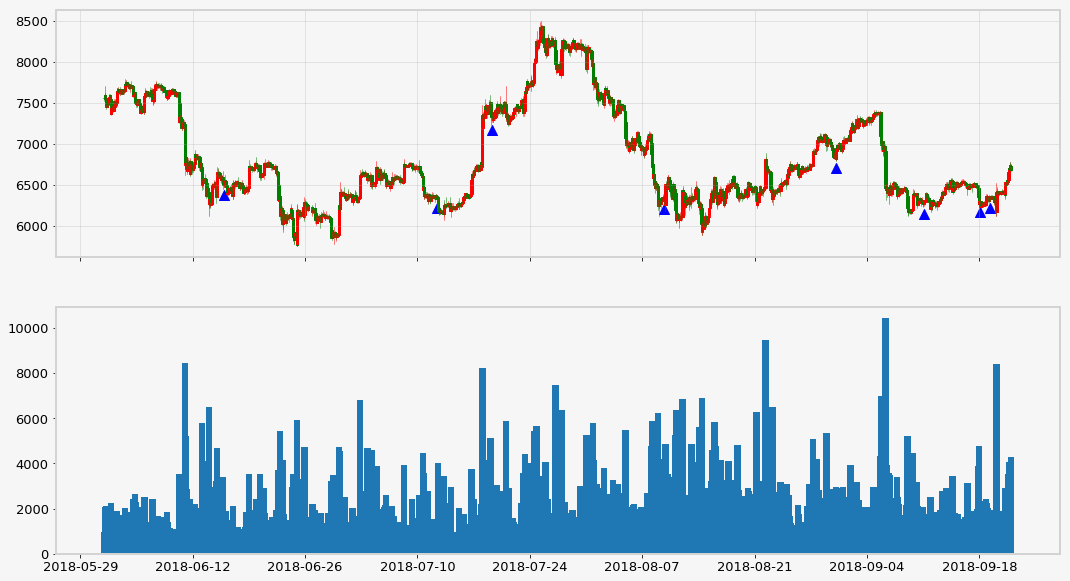

In [19]:
data1H = Time_dict.set_index('datetime')
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1H = HFDataView()
dv1H.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

from matplotlib.pylab import date2num

data1H['candleTime'] = list(map(date2num, data1H.index))
candle = data1H.reindex_axis(["candleTime", "open", "high", "low", "close"], 1).values

Morningstar = dv1H.add_formula('Morningstar', "If((Ta('CDLMORNINGSTAR', 0, open, high, low, close, volume)==100),100,0)", add_data=True)
MorningstarVolume = dv1H.get_ts('Morningstar', date_type='datetime')
MorningstarVolumeX = MorningstarVolume[MorningstarVolume['BTCUSDT:binance']==100].index
MorningstarVolumeY = data1H.loc[MorningstarVolumeX].low-100

draw_candle(candle, MorningstarVolumeX, MorningstarVolumeY)


# 4、调用alpha101、alpha191、技术因子、candleresearch或者自己创造衍生因子，要求：任意两个因子，进行画图观察，主要例子看alpha101research和candleresearch，写研究报告（画了什么因子，思考了什么现象，对现象进行描述）


https://github.com/ChannelCMT/formula/wiki

数据类型和周期自定


### alpha191中的alpha29

In [17]:
from time import time
import warnings

warnings.filterwarnings('ignore')

from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'BTCUSDT:binance', 'freq': '1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props)
print(time()-start)

3.7609829902648926


In [19]:
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1H = HFDataView()
dv1H.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

Initialize dataview success.


该因子是基于过去一段时间收盘价的涨幅乘上当前交易量。交易量可以反应流动性，价差涨幅可以反映最近价格波动，把这两个因素相乘，我认为可以反映价格在接下来的走势

因子写入

In [46]:
alpha29 = dv1H.add_formula('alpha29',
                             "(close-Delay(close,2))/Delay(close,2)*volume" 
                             , add_data=True)

Field [alpha29] is overwritten.


与收盘价的走势图

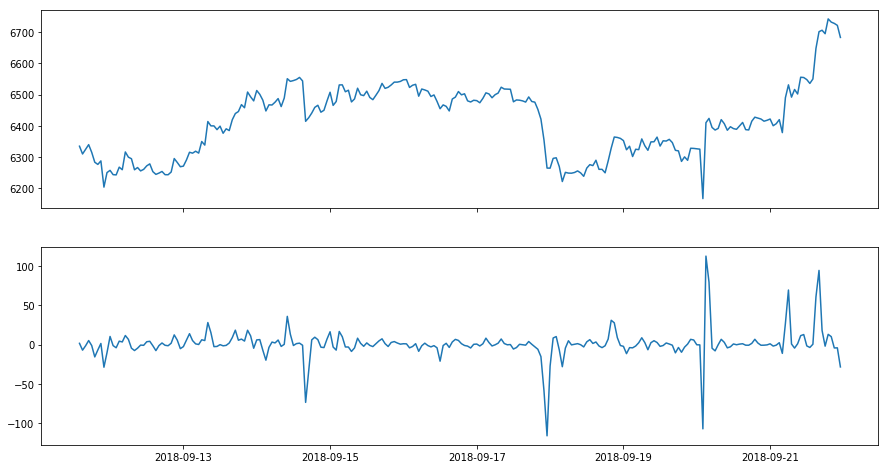

In [47]:
import matplotlib.pyplot as plt
def plot_chart(close,alpha):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[-250:])
    ax1.plot(alpha.iloc[-250:])
    # plt.savefig('good')
    plt.show()
plot_chart(dv1H.get_ts('close',date_type='datetime'),dv1H.get_ts('alpha29',date_type='datetime'))

上图可以看出，每当alpha29因子发生大波动时，收盘也也同时发生了大波动，这印证了我的初步想法

下面绘制该比特币当期收益率与当期的alpha29因子的散点图以及计算相关系数

In [26]:
import pandas as pd

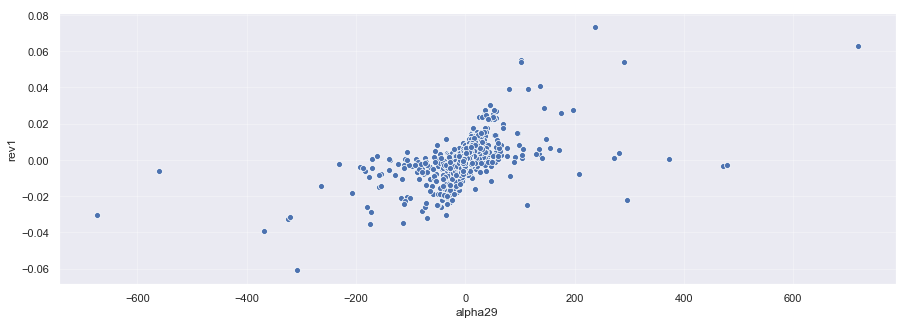

In [151]:
new = pd.concat([dv1H.get_ts('close',date_type='datetime'),dv1H.get_ts('alpha29',date_type='datetime')]\
                ,axis=1,keys=['close','alpha29'])
NEW = new.swaplevel(axis=1)['BTCUSDT:binance']

import seaborn as sns
sns.set()
NEW['rev1'] = NEW['close'].pct_change(1).shift(1)
plt.figure(figsize=(15,5))
sns.scatterplot(x="alpha29", y="rev1",
                data=NEW)

In [152]:
print('相关系数:%.2f'%NEW['rev1'].corr(NEW['alpha29']))

相关系数:0.51


结论：可以看出，该因子alpha29与当期收益率有着不小的相关性

### alpha191中的alpha66

In [77]:
alpha66 = dv1H.add_formula('alpha66', "(close-Ts_Mean(close,5))/Ts_Mean(close,5)*100",add_data=True)

Field [alpha66] is overwritten.


alpha66是一个价格趋势因子，用（当前价格-过去几天价格均值）/过去几天的均值，反映当前是否有价格上涨趋势。我先画出收盘价与alpha66因子的时序图

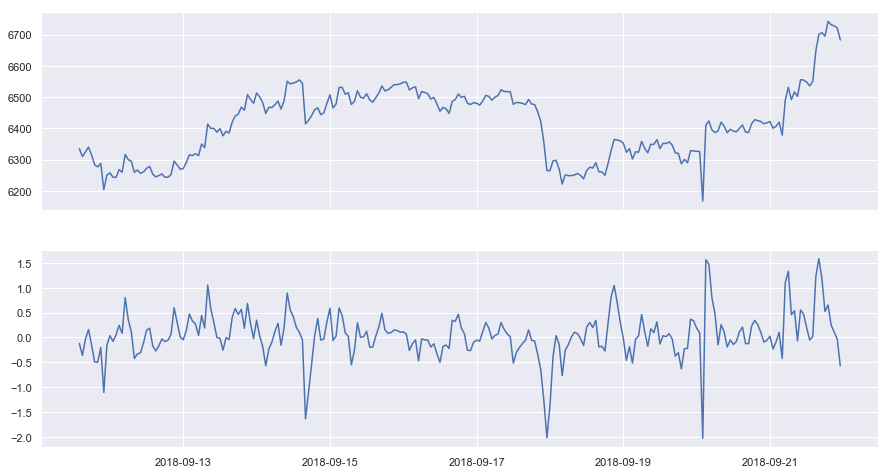

In [78]:
plot_chart(dv1H.get_ts('close',date_type='datetime'),dv1H.get_ts('alpha66',date_type='datetime'))

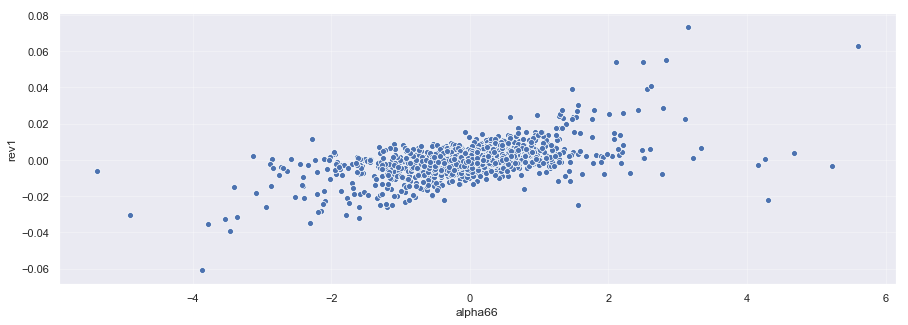

In [153]:
new = pd.concat([dv1H.get_ts('close',date_type='datetime'),dv1H.get_ts('alpha66',date_type='datetime')]\
                ,axis=1,keys=['close','alpha66'])
NEW = new.swaplevel(axis=1)['BTCUSDT:binance']

NEW['rev1'] = NEW['close'].pct_change(1).shift(1)
plt.figure(figsize=(15,5))
sns.scatterplot(x="alpha66", y="rev1",
                data=NEW)

In [154]:
print('相关系数:%.2f'%NEW['rev1'].corr(NEW['alpha66']))

相关系数:0.54


当alpha66因子当期值大于0时，当期上涨的概率为64.2%

In [144]:
((NEW['alpha66']>0) & (NEW['rev1']<0)).sum() / (NEW['alpha66']>0).sum()

0.5478955007256894

当alpha66因子当期值小于0时，当期下跌的概率为64%

In [145]:
((NEW['alpha66']<0) & (NEW['rev1']>0)).sum() / (NEW['alpha66']<0).sum()

0.5615384615384615

alpha66分布图

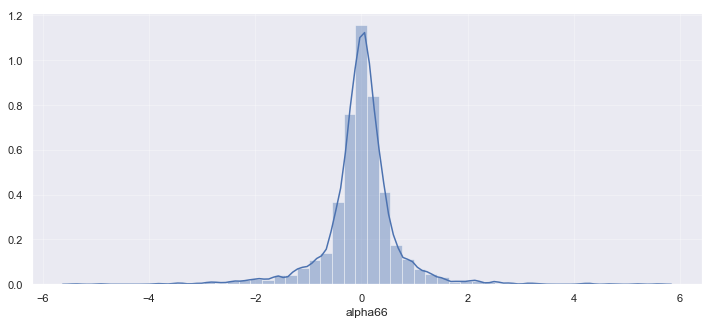

In [146]:
plt.figure(figsize=(12,5))
sns.distplot(NEW['alpha66'].dropna())

下计算alpha66不同阈值时，上涨或下跌的概率

In [147]:
mean = NEW['alpha66'].mean() 
std = NEW['alpha66'].std()

In [157]:
import numpy as np
alpha66_quantiles = []
probs = []
for mutiple in np.arange(-3,3.1,0.1):
    quantile = mean + mutiple*std
    alpha66_quantiles.append(quantile)
    if mutiple>=0:
        prob = ((NEW['alpha66']> quantile) & (NEW['rev1']>0)).sum() / (NEW['alpha66']>quantile).sum()
    else:
        prob = ((NEW['alpha66']< quantile) & (NEW['rev1']<0)).sum() / (NEW['alpha66']<quantile).sum()
    probs.append(prob)

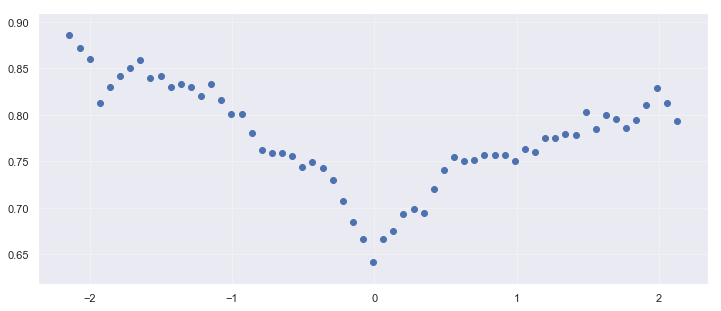

In [158]:
plt.figure(figsize=(12,5))
plt.scatter(alpha66_quantiles,probs)

可以看出，当alpha66因子值离原点越远，当期涨跌关系越明显

# 5、观察两个因子，和价格图有什么联系，如果是蜡烛图，和成交量有什么联系，怎么找到相应的信号，提出自己信号进出场的假设。（分别完成两个因子的信号假设）

信号进出场假设：可以借鉴MastatiscResearch，但不要将思路假设局限在均线上，可以观察大盘上的其他现象来写信号假设，也可以进行同时满足多个因子的信号来设计信号假设等等。

此处需要说出联系、找到的信号、你的信号进出场假设是什么

在题目4，已经做出了两个因子关于价格图的联系，以及研究报告，因此，我在4的基础上提出信号假设

alpha29假设：当alpha29因子值大于0时，开多仓持有，持有期为1。当alpha29因子值小于0时，开空仓持有，持有期为1

alpha66假设：当alpha66因子值大于1时，开多仓持有，持有期为1。当alpha66因子值小于-1时，开空仓持有，持有期为1

# 6、将你的其中一个假设落实，如果能完成两个更好，但不强求

利用TimingSignal最后输出long、short、long_short这三个绩效表出来


## alpha29因子假设

In [159]:
# 进场信号
long = dv1H.add_formula("long","If(alpha29>0,2,0)", add_data=True)
short = dv1H.add_formula("short","If(alpha29<0,-2,0)", add_data=True)

# 出场信号

#close_long = dv1H.add_df("closeLong","If(Delta(alpha29,-2)>0,1,0)", add_data=True)
#close_short = dv1H.add_df("closeShort","If(Delta(alpha29,-2)<0,-1,0)", add_data=True)

Field [long] is overwritten.
Field [short] is overwritten.


In [160]:
#通过测试报告，看多空信号的绩效，这里是定义报告格式
from jaqs_fxdayu.research import TimingDigger

td29 = TimingDigger(output_folder=".", output_format='pdf',signal_name='Alpha29')

def TimingSignal(td, dv, long='long', short='short',closeLong='closeLong', closeShort='closeShort'\
                 , mhp=1,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        #exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        #stoploss=-sl,  # 止损百分比 负数 可为空
        #stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        #exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        #stoploss=-sl,  # 止损百分比 负数 可为空
        #stopprofit=sp,  # 止盈百分比 正数 可为空
    )

In [161]:
TimingSignal(td29, dv1H, mhp=1)#调取数据

Nan Data Count (should be zero) : 0;  Percentage of effective data: 50%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 48%


In [162]:
td29.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                        win     loss       all
t-stat               13.541  -26.366    -4.985
p-value               0.000    0.000     0.000
mean                  0.004   -0.004    -0.001
std                   0.007    0.004     0.007
info_ratio            0.591   -0.909    -0.135
skewness              5.841   -3.030     2.453
kurtosis             43.228   12.237    27.465
pct5                  0.000   -0.012    -0.009
pct25                 0.001   -0.005    -0.004
pct50                 0.002   -0.003    -0.001
pct75                 0.004   -0.001     0.002
pct95                 0.012   -0.000     0.007
occurance           526.000  842.000  1368.000
win_ratio               NaN      NaN     0.385
win_mean/loss_mean      NaN      NaN     1.011


In [163]:
td29.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                        win     loss       all
t-stat               15.700  -25.753    -4.831
p-value               0.000    0.000     0.000
mean                  0.004   -0.004    -0.001
std                   0.006    0.004     0.006
info_ratio            0.717   -0.895    -0.134
skewness              3.640   -3.695     0.936
kurtosis             19.545   20.037    13.590
pct5                  0.000   -0.011    -0.009
pct25                 0.001   -0.005    -0.003
pct50                 0.002   -0.003    -0.001
pct75                 0.005   -0.001     0.001
pct95                 0.017   -0.000     0.008
occurance           481.000  829.000  1310.000
win_ratio               NaN      NaN     0.367
win_mean/loss_mean      NaN      NaN     1.122


In [164]:
td29.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                         win      loss       all
t-stat                20.491   -36.865    -6.942
p-value                0.000     0.000     0.000
mean                   0.004    -0.004    -0.001
std                    0.007     0.004     0.007
info_ratio             0.646    -0.902    -0.134
skewness               4.991    -3.353     1.762
kurtosis              34.878    15.993    21.329
pct5                   0.000    -0.011    -0.009
pct25                  0.001    -0.005    -0.003
pct50                  0.002    -0.003    -0.001
pct75                  0.005    -0.001     0.002
pct95                  0.014    -0.000     0.007
occurance           1007.000  1671.000  2678.000
win_ratio                NaN       NaN     0.376
win_mean/loss_mean       NaN       NaN     1.064


## alpha66因子假设

In [165]:
long = dv1H.add_formula("long66","If(alpha66>1,2,0)", add_data=True)
short = dv1H.add_formula("short66","If(alpha29<-1,-2,0)", add_data=True)

Field [long66] is overwritten.
Field [short66] is overwritten.


In [166]:
#通过测试报告，看多空信号的绩效，这里是定义报告格式
from jaqs_fxdayu.research import TimingDigger

td66 = TimingDigger(output_folder=".", output_format='pdf',signal_name='Alpha66')

def TimingSignal(td, dv, long='long66', short='short66',closeLong='closeLong', closeShort='closeShort'\
                 , mhp=1,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        #exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        #stoploss=-sl,  # 止损百分比 负数 可为空
        #stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        #exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        #stoploss=-sl,  # 止损百分比 负数 可为空
        #stopprofit=sp,  # 止盈百分比 正数 可为空
    )

In [167]:
TimingSignal(td66, dv1H, mhp=1)#调取数据

Nan Data Count (should be zero) : 0;  Percentage of effective data: 5%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 41%


In [168]:
td66.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                       win    loss      all
t-stat               5.776  -8.735   -2.934
p-value              0.000   0.000    0.004
mean                 0.004  -0.004   -0.002
std                  0.004   0.004    0.006
info_ratio           0.913  -0.965   -0.265
skewness             3.341  -2.081    0.032
kurtosis            14.159   5.454    5.090
pct5                 0.000  -0.012   -0.011
pct25                0.002  -0.006   -0.004
pct50                0.003  -0.003   -0.001
pct75                0.005  -0.001    0.002
pct95                0.010  -0.000    0.006
occurance           41.000  83.000  124.000
win_ratio              NaN     NaN    0.331
win_mean/loss_mean     NaN     NaN    0.927


In [169]:
td66.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                        win     loss       all
t-stat               14.222  -24.838    -4.487
p-value               0.000    0.000     0.000
mean                  0.005   -0.004    -0.001
std                   0.006    0.004     0.007
info_ratio            0.708   -0.934    -0.135
skewness              3.519   -3.349     1.212
kurtosis             18.179   16.858    13.094
pct5                  0.000   -0.011    -0.009
pct25                 0.001   -0.005    -0.004
pct50                 0.002   -0.003    -0.001
pct75                 0.005   -0.001     0.001
pct95                 0.017   -0.000     0.009
occurance           405.000  708.000  1113.000
win_ratio               NaN      NaN     0.364
win_mean/loss_mean      NaN      NaN     1.137


In [170]:
td66.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                        win     loss       all
t-stat               15.133  -26.340    -5.140
p-value               0.000    0.000     0.000
mean                  0.004   -0.004    -0.001
std                   0.006    0.004     0.007
info_ratio            0.717   -0.937    -0.146
skewness              3.561   -3.200     1.130
kurtosis             18.708   15.438    12.637
pct5                  0.000   -0.011    -0.009
pct25                 0.001   -0.005    -0.004
pct50                 0.002   -0.003    -0.001
pct75                 0.005   -0.001     0.001
pct95                 0.017   -0.000     0.008
occurance           446.000  791.000  1237.000
win_ratio               NaN      NaN     0.361
win_mean/loss_mean      NaN      NaN     1.116
